In [1]:
# ====================================================
# LOAD REQUIRED LIBRARIES AND DATA SETS
# ====================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from scipy.stats import chi2_contingency
import math
import matplotlib.pyplot as plt
import os
warnings.filterwarnings('ignore')

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
train_df = pd.read_csv("/kaggle/input/itmo-flat-price-prediction-2025-2026/Archive2025/data.csv")
test_df = pd.read_csv("/kaggle/input/itmo-flat-price-prediction-2025-2026/Archive2025/test.csv")

/kaggle/input/itmo-flat-price-prediction-2025-2026/Archive2025/solution_example_full.csv
/kaggle/input/itmo-flat-price-prediction-2025-2026/Archive2025/solution_example.csv
/kaggle/input/itmo-flat-price-prediction-2025-2026/Archive2025/test.csv
/kaggle/input/itmo-flat-price-prediction-2025-2026/Archive2025/data.csv
/kaggle/input/itmo-flat-price-prediction-2025-2026/archive/solution_example_full.csv
/kaggle/input/itmo-flat-price-prediction-2025-2026/archive/solution_example.csv
/kaggle/input/itmo-flat-price-prediction-2025-2026/archive/test.csv
/kaggle/input/itmo-flat-price-prediction-2025-2026/archive/data.csv


In [2]:
# ===================================================================
# EXPLORATORY DATA ANALYSIS
# ===================================================================

# Create output directory
output_dir = '/kaggle/working/eda'
os.makedirs(output_dir, exist_ok=True)

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("="*80)
print("EXPLORATORY DATA ANALYSIS - FLAT PRICE PREDICTION")
print("="*80)

train_df = train_df.drop(columns=['index'], errors='ignore')
print("dropped 'index'")

EXPLORATORY DATA ANALYSIS - FLAT PRICE PREDICTION
dropped 'index'


In [3]:
# ====================================================
# 1. DATASET OVERVIEW
# ====================================================

print(f"Dataset Shape: {train_df.shape}")
print(f"Number of Records: {train_df.shape[0]}")
print(f"Number of Features: {train_df.shape[1]}")

print("\nData Types:")
print(train_df.dtypes)


Dataset Shape: (100000, 18)
Number of Records: 100000
Number of Features: 18

Data Types:
kitchen_area              int64
bath_area                 int64
other_area              float64
gas                      object
hot_water                object
central_heating          object
extra_area                int64
extra_area_count          int64
year                      int64
ceil_height             float64
floor_max                 int64
floor                     int64
total_area              float64
bath_count                int64
extra_area_type_name     object
district_name            object
rooms_count               int64
price                     int64
dtype: object


In [4]:
# ====================================================
# 2. DATA QUALITY ASSESSMENT
# ====================================================

# ====================================================
# 2.1 Missing values summary
# ====================================================

missing = train_df.isna().sum()
missing_pct = (missing / len(train_df) * 100).round(2)

missing_summary = pd.DataFrame({
    'Missing Count': missing,
    'Missing %': missing_pct
})

missing_summary = missing_summary[missing_summary['Missing Count'] > 0]

print(missing_summary if not missing_summary.empty else "No missing values")


# ====================================================
# 2.2 Duplicate records
# ====================================================

print(f"Number of duplicate rows: {train_df.duplicated().sum()}")


# ====================================================
# 2.3 Total memory usage
# ====================================================

print(f"Total memory usage: {train_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

No missing values
Number of duplicate rows: 0
Total memory usage: 35.65 MB


3. TARGET VARIABLE ANALYSIS
count    1.000000e+05
mean     1.651210e+07
std      5.977483e+06
min      4.680056e+06
25%      1.220732e+07
50%      1.536205e+07
75%      1.966873e+07
max      4.440331e+07
Name: price, dtype: float64
Skewness: 1.01
Kurtosis: 1.093


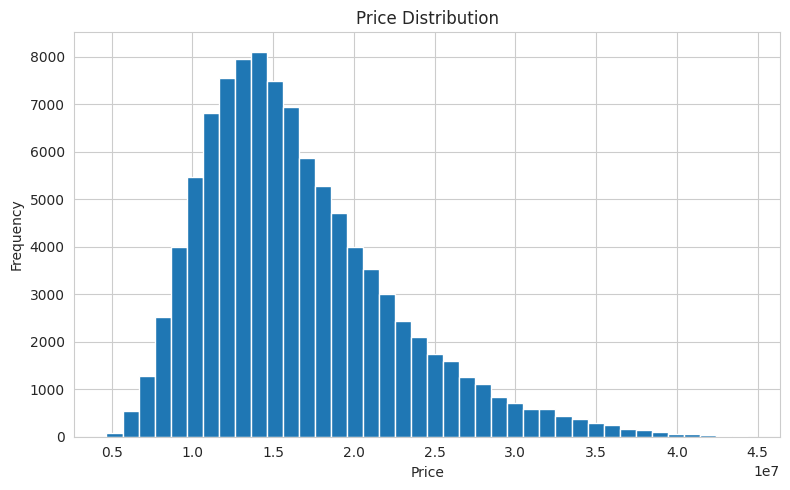

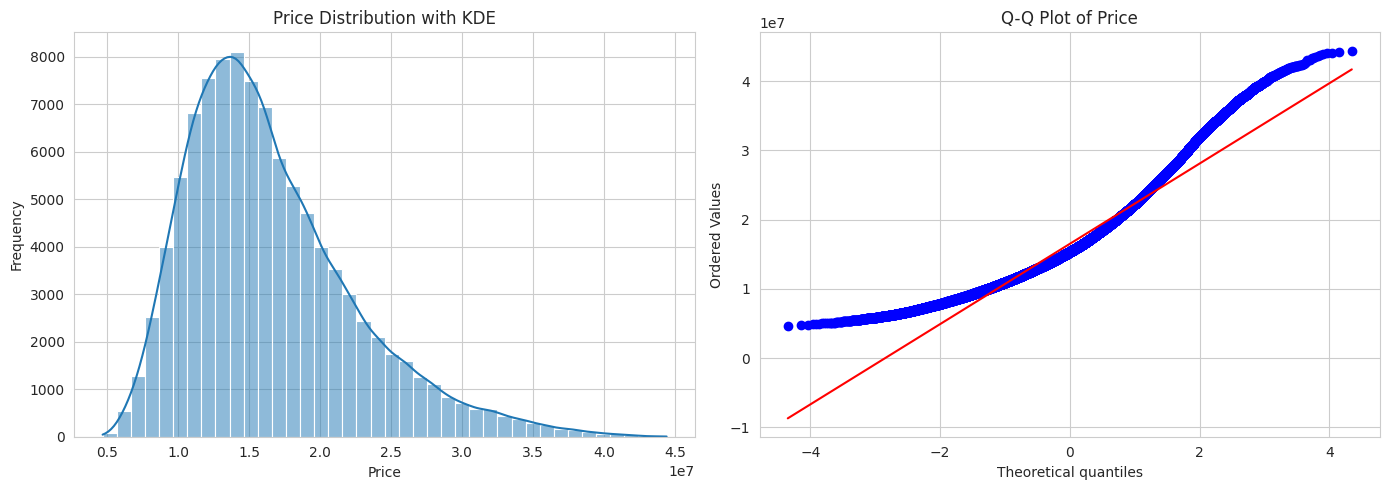

Outlier Detection using IQR Method:
Lower Bound: 1,015,194
Upper Bound: 30,860,852
Number of Outliers: 2882
Percentage of Outliers: 2.88%


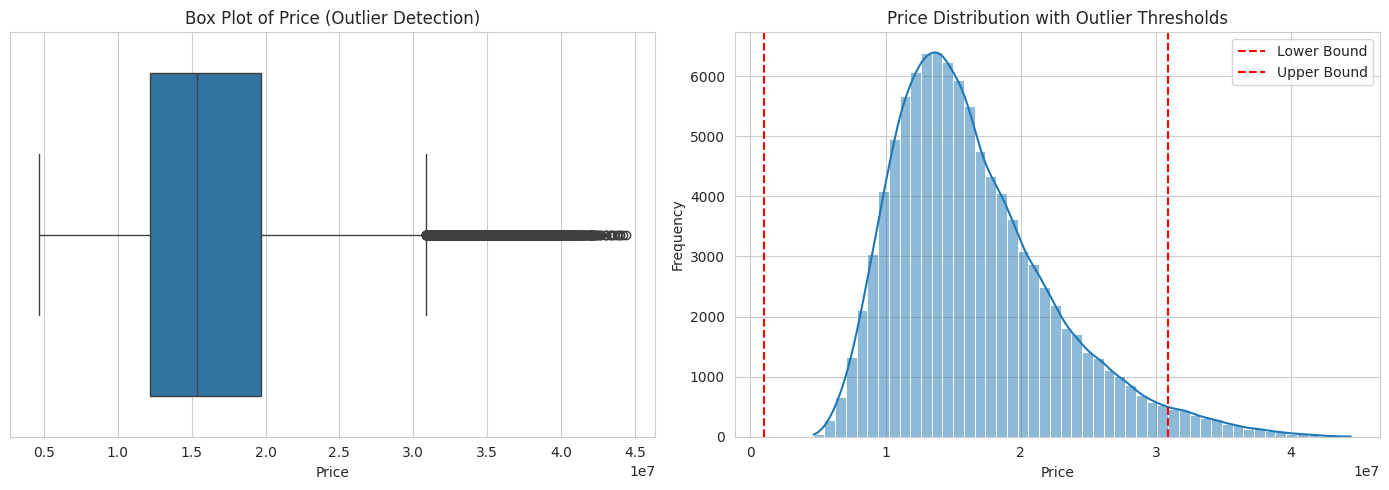

Outlier Values (Top 5):
60151    44403310
1305     44203938
47317    44017519
57403    44012028
82179    43886109
Name: price, dtype: int64


In [5]:
# ====================================================
# 3. TARGET VARIABLE ANALYSIS
# ====================================================
print("=" * 40)
print("3. TARGET VARIABLE ANALYSIS")
print("=" * 40)

# Define target variable
target = 'price'
price = train_df[target].dropna()

# ====================================================
# 3.1 Distribution and skewness
# ====================================================

print(price.describe())
print(f"Skewness: {price.skew():.2f}")
print(f"Kurtosis: {price.kurtosis():.3f}")

# ----------------------------------------------------
# Price distribution histogram
# ----------------------------------------------------
plt.figure(figsize=(8, 5))
plt.hist(price, bins=40)
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig(f"{output_dir}/01_price_distribution.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

# ----------------------------------------------------
# Histogram with KDE + Q-Q Plot
# ----------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram with KDE
sns.histplot(price, bins=40, kde=True, ax=axes[0])
axes[0].set_title("Price Distribution with KDE")
axes[0].set_xlabel("Price")
axes[0].set_ylabel("Frequency")

# Q-Q plot (normality check)
stats.probplot(price, dist="norm", plot=axes[1])
axes[1].set_title("Q-Q Plot of Price")

plt.tight_layout()
plt.savefig(f"{output_dir}/02_price_distribution_kde_qq.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

# ====================================================
# 3.2 Outlier assessment
# ====================================================

# Calculate IQR bounds
Q1 = price.quantile(0.25)
Q3 = price.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = price[(price < lower_bound) | (price > upper_bound)]

print("Outlier Detection using IQR Method:")
print(f"Lower Bound: {lower_bound:,.0f}")
print(f"Upper Bound: {upper_bound:,.0f}")
print(f"Number of Outliers: {len(outliers)}")
print(f"Percentage of Outliers: {(len(outliers) / len(price)) * 100:.2f}%")

# ----------------------------------------------------
# Box plot + Histogram
# ----------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
sns.boxplot(x=price, ax=axes[0])
axes[0].set_title("Box Plot of Price (Outlier Detection)")
axes[0].set_xlabel("Price")

# Histogram
sns.histplot(price, bins=50, kde=True, ax=axes[1])
axes[1].axvline(lower_bound, color='red', linestyle='--', label='Lower Bound')
axes[1].axvline(upper_bound, color='red', linestyle='--', label='Upper Bound')
axes[1].set_title("Price Distribution with Outlier Thresholds")
axes[1].set_xlabel("Price")
axes[1].set_ylabel("Frequency")
axes[1].legend()

# Adjust layout and save
plt.tight_layout()
plt.savefig(f"{output_dir}/04_price_outlier_analysis.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

print("Outlier Values (Top 5):")
print(outliers.sort_values(ascending=False).head())


        kitchen_area      bath_area     other_area     extra_area  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean       16.494980      21.485220      28.156113       9.989530   
std         5.761893       8.645616      20.403852       5.777662   
min         7.000000       7.000000      11.000130       0.000000   
25%        11.000000      14.000000      12.987989       5.000000   
50%        16.000000      21.000000      18.901809      10.000000   
75%        21.000000      29.000000      36.874833      15.000000   
max        26.000000      36.000000      90.999638      20.000000   

       extra_area_count           year    ceil_height      floor_max  \
count     100000.000000  100000.000000  100000.000000  100000.000000   
mean           1.001600    1960.126790       3.127614       6.380690   
std            0.707377      34.622494       0.807468       3.939299   
min            0.000000    1900.000000       2.500000       1.000000   
25%            1.0

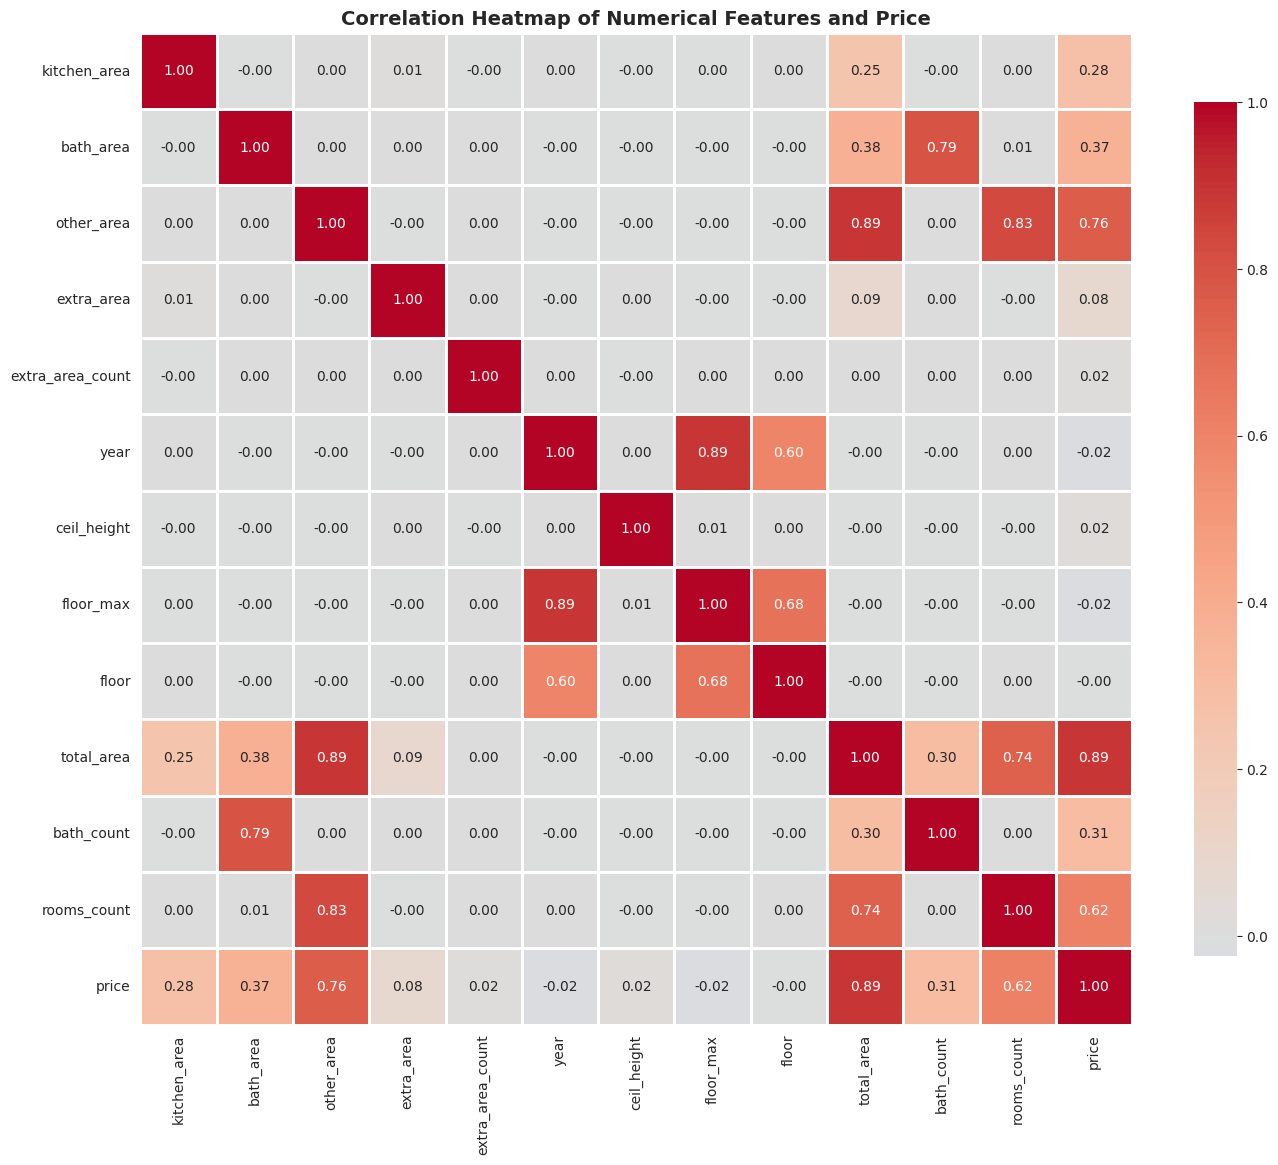

In [6]:
# ====================================================
# 4. NUMERICAL FEATURE ANALYSIS
# ====================================================

# Numerical feature columns (exclude target)
numerical_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
numerical_cols = numerical_cols.drop(target, errors='ignore')

# ====================================================
# 4.1 Summary statistics
# ====================================================

print(train_df[numerical_cols].describe())


# ====================================================
# 4.2 Correlation with price
# ====================================================
corr_df = train_df[list(numerical_cols) + ['price']]

corr = corr_df.corr()['price'].drop('price').sort_values(ascending=False)
print("\nCorrelation with Price")
print(corr)

# Correlation heatmap
plt.figure(figsize=(14, 12))
corr_df = train_df[list(numerical_cols) + ['price']]
correlation_matrix = corr_df.corr()

sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=1,
    cbar_kws={"shrink": 0.8}
)

plt.title('Correlation Heatmap of Numerical Features and Price',
          fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{output_dir}/03_numerical_features_correlation_heatmap.png',
            dpi=300, bbox_inches='tight')
plt.show()
plt.close()

Outlier Detection for Numerical Features using IQR Method
Column: kitchen_area
  Lower Bound: -4.00
  Upper Bound: 36.00
  Outliers: 0
  Outlier %: 0.00%
--------------------------------------------------
Column: bath_area
  Lower Bound: -8.50
  Upper Bound: 51.50
  Outliers: 0
  Outlier %: 0.00%
--------------------------------------------------
Column: other_area
  Lower Bound: -22.84
  Upper Bound: 72.71
  Outliers: 5868
  Outlier %: 5.87%
--------------------------------------------------
Column: extra_area
  Lower Bound: -10.00
  Upper Bound: 30.00
  Outliers: 0
  Outlier %: 0.00%
--------------------------------------------------
Column: extra_area_count
  Lower Bound: -0.50
  Upper Bound: 3.50
  Outliers: 0
  Outlier %: 0.00%
--------------------------------------------------
Column: year
  Lower Bound: 1,840.00
  Upper Bound: 2,080.00
  Outliers: 0
  Outlier %: 0.00%
--------------------------------------------------
Column: ceil_height
  Lower Bound: 0.62
  Upper Bound: 5.62
 

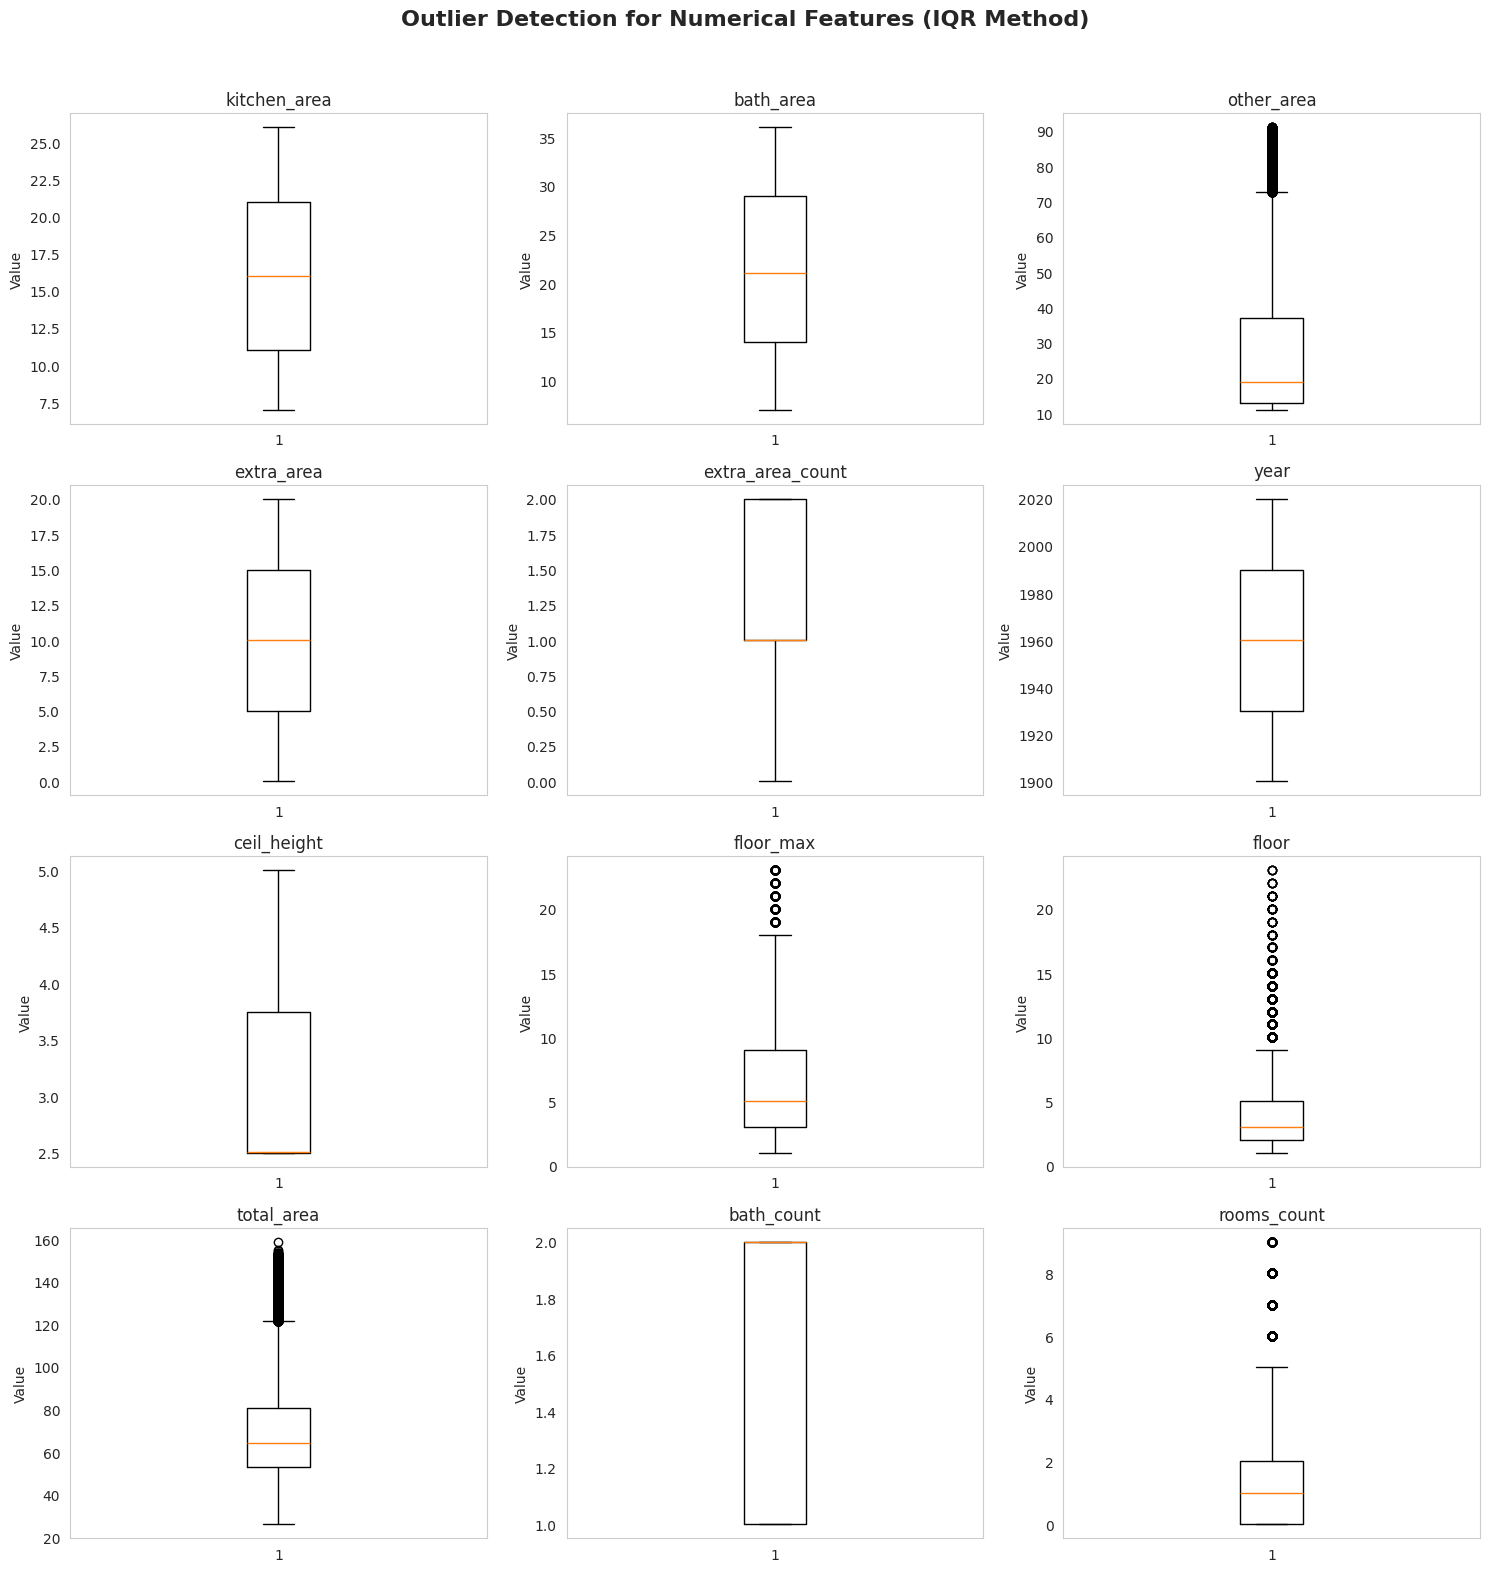

In [7]:
# ====================================================
# 4.3 Outlier Assessment of numerical features (IQR Method)
# ====================================================
print("Outlier Detection for Numerical Features using IQR Method")
print("=" * 70)

num_cols = len(numerical_cols)

# Automatically choose grid layout
cols = 3
rows = math.ceil(num_cols / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()

for idx, column in enumerate(numerical_cols):
    series = train_df[column].dropna()

    # -----------------------------
    # IQR calculation
    # -----------------------------
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = series[(series < lower_bound) | (series > upper_bound)]

    # -----------------------------
    # Print summary
    # -----------------------------
    print(f"Column: {column}")
    print(f"  Lower Bound: {lower_bound:,.2f}")
    print(f"  Upper Bound: {upper_bound:,.2f}")
    print(f"  Outliers: {len(outliers)}")
    print(f"  Outlier %: {(len(outliers) / len(series)) * 100:.2f}%")
    print("-" * 50)

    # -----------------------------
    # Box plot
    # -----------------------------
    ax = axes[idx]
    ax.boxplot(series, vert=True)
    ax.set_title(column)
    ax.set_ylabel("Value")
    ax.grid(False)

# Remove unused subplots
for i in range(idx + 1, len(axes)):
    fig.delaxes(axes[i])

fig.suptitle(
    "Outlier Detection for Numerical Features (IQR Method)",
    fontsize=16,
    fontweight="bold"
)

plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.savefig(
    f"{output_dir}/04_outlier_detection_for_numerical_features.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()
plt.close()


Mutual Information Scores (Non-Linear Dependency):
             Feature  Mutual_Information
9         total_area            1.103464
2         other_area            0.375318
11       rooms_count            0.229740
1          bath_area            0.133614
10        bath_count            0.086291
0       kitchen_area            0.069739
3         extra_area            0.005888
5               year            0.005579
7          floor_max            0.000000
6        ceil_height            0.000000
4   extra_area_count            0.000000
8              floor            0.000000

Linear vs Non-Linear Dependency Comparison:
                  Correlation  Mutual_Information
total_area           0.888708            1.103464
other_area           0.757588            0.375318
rooms_count          0.616095            0.229740
bath_area            0.373925            0.133614
bath_count           0.310200            0.086291
kitchen_area         0.278471            0.069739
extra_area           

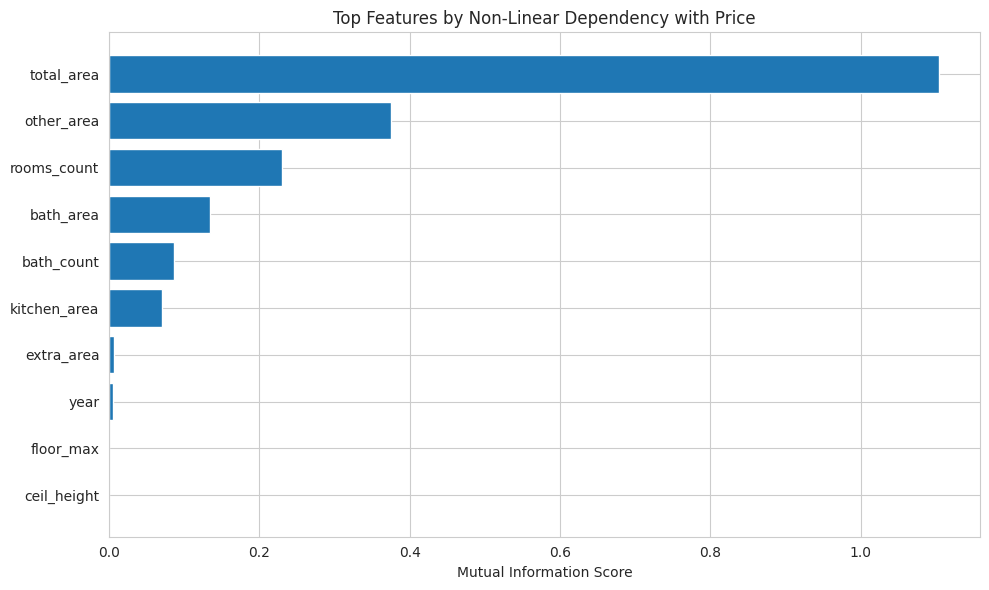

In [8]:
# ====================================================
# 4.4 Non-Linear Dependency Analysis
# ====================================================

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression

# -----------------------------
# Data
# -----------------------------
X_num = train_df[numerical_cols]
y = train_df['price']

# -----------------------------
# Mutual Information
# -----------------------------
mi_scores = mutual_info_regression(
    X_num,
    y,
    random_state=42
)

mi_df = (
    pd.DataFrame({
        'Feature': numerical_cols,
        'Mutual_Information': mi_scores
    })
    .sort_values('Mutual_Information', ascending=False)
)

print("Mutual Information Scores (Non-Linear Dependency):")
print(mi_df)

# -----------------------------
# Correlation vs Mutual Information
# -----------------------------
corr_series = (
    train_df[numerical_cols]
    .corrwith(train_df['price'])
    .rename('Correlation')
)

comparison_df = (
    pd.concat(
        [corr_series, mi_df.set_index('Feature')['Mutual_Information']],
        axis=1
    )
    .sort_values('Mutual_Information', ascending=False)
)

print("\nLinear vs Non-Linear Dependency Comparison:")
print(comparison_df)

# -----------------------------
# Visualization (Top Features)
# -----------------------------
top_k = 10
plot_df = comparison_df.head(top_k)

plt.figure(figsize=(10, 6))
plt.barh(plot_df.index, plot_df['Mutual_Information'])
plt.xlabel("Mutual Information Score")
plt.title("Top Features by Non-Linear Dependency with Price")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(
    f"{output_dir}/05_top_features_by_non_linear_dependency_with_price.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()


Category distributions


gas distribution
gas: 2 unique values
     Count  Percent (%)
gas                    
No   50043        50.04
Yes  49957        49.96

hot_water distribution
hot_water: 2 unique values
           Count  Percent (%)
hot_water                    
Yes        65042        65.04
No         34958        34.96

central_heating distribution
central_heating: 2 unique values
                 Count  Percent (%)
central_heating                    
Yes              89977        89.98
No               10023        10.02

extra_area_type_name distribution
extra_area_type_name: 2 unique values
                      Count  Percent (%)
extra_area_type_name                    
loggia                50163        50.16
balcony               49837        49.84

district_name distribution
district_name: 7 unique values
               Count  Percent (%)
district_name                    
Moskovskij     14321        14.32
Centralnyj     14314        14.31
Petrogradskij  14312        14.

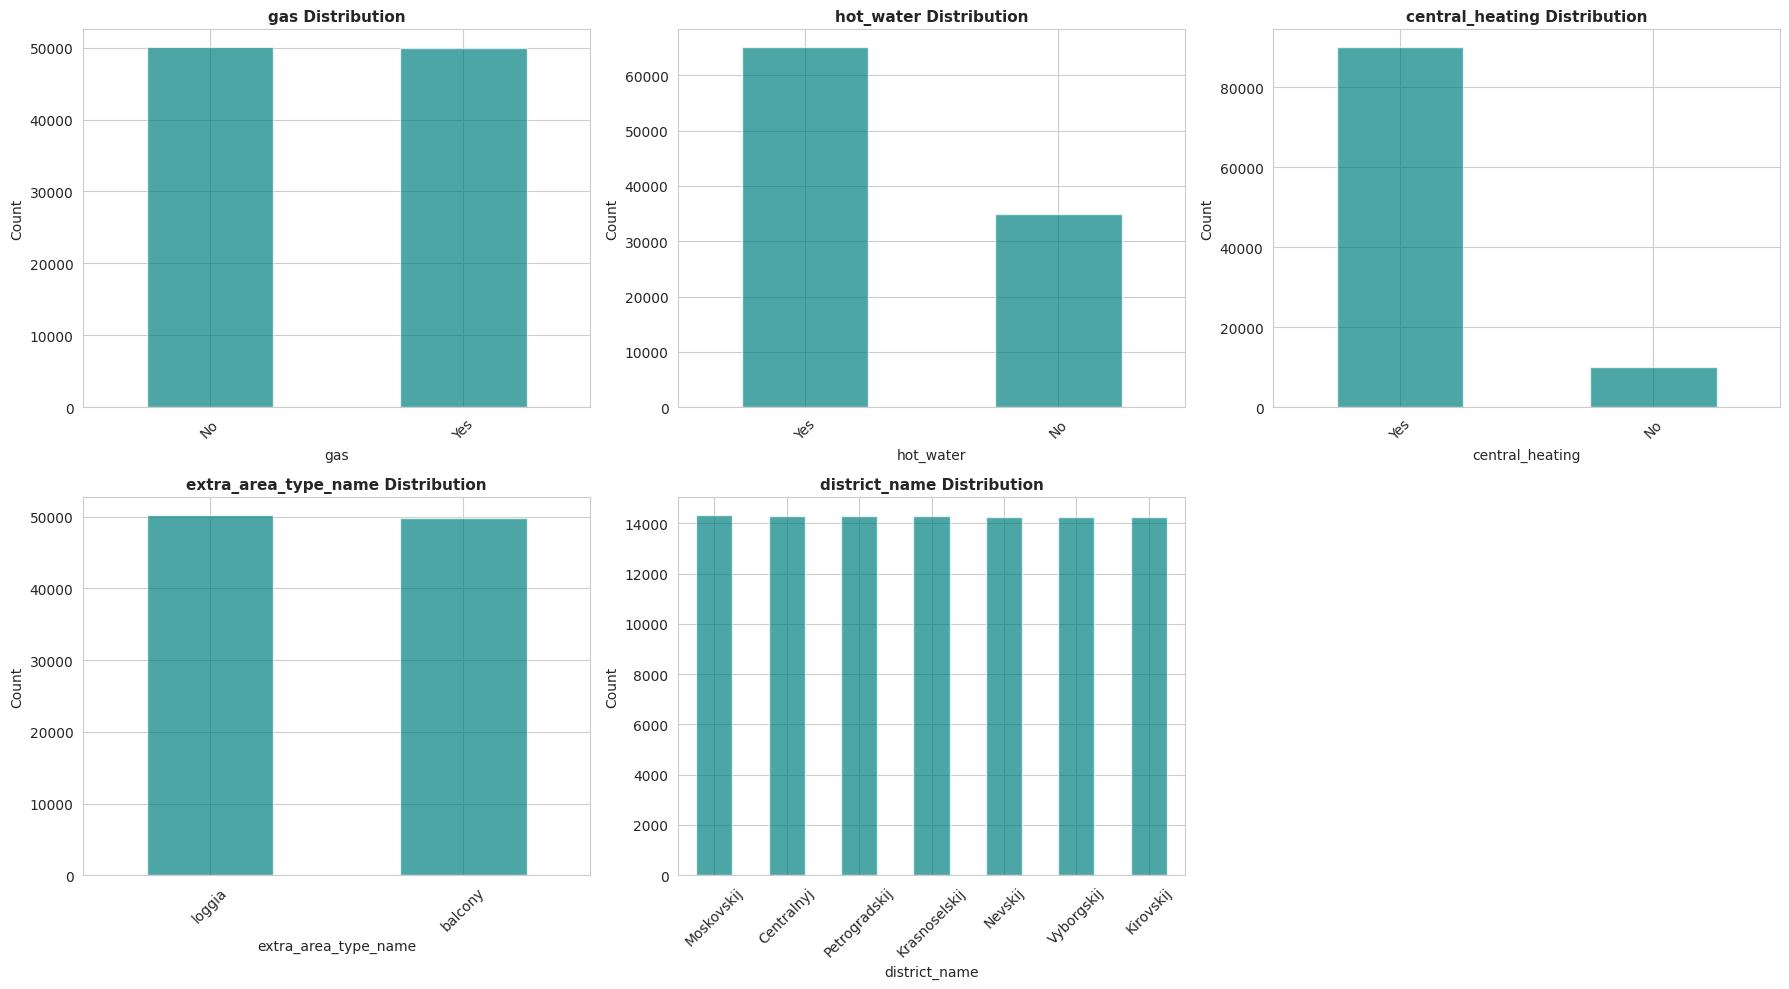


Price Variation Across Categories


Price statistics by gas
     count          mean      median           std
gas                                               
Yes  49957  1.659712e+07  15430172.0  6.012669e+06
No   50043  1.642722e+07  15288751.0  5.940997e+06

Price statistics by hot_water
           count          mean      median           std
hot_water                                               
Yes        65042  1.653614e+07  15397534.0  5.970929e+06
No         34958  1.646737e+07  15284517.5  5.989488e+06

Price statistics by central_heating
                 count          mean      median           std
central_heating                                               
Yes              89977  1.668518e+07  15515954.0  5.999869e+06
No               10023  1.495830e+07  13853688.0  5.535628e+06

Price statistics by extra_area_type_name
                      count          mean      median           std
extra_area_type_name                                               
loggia   

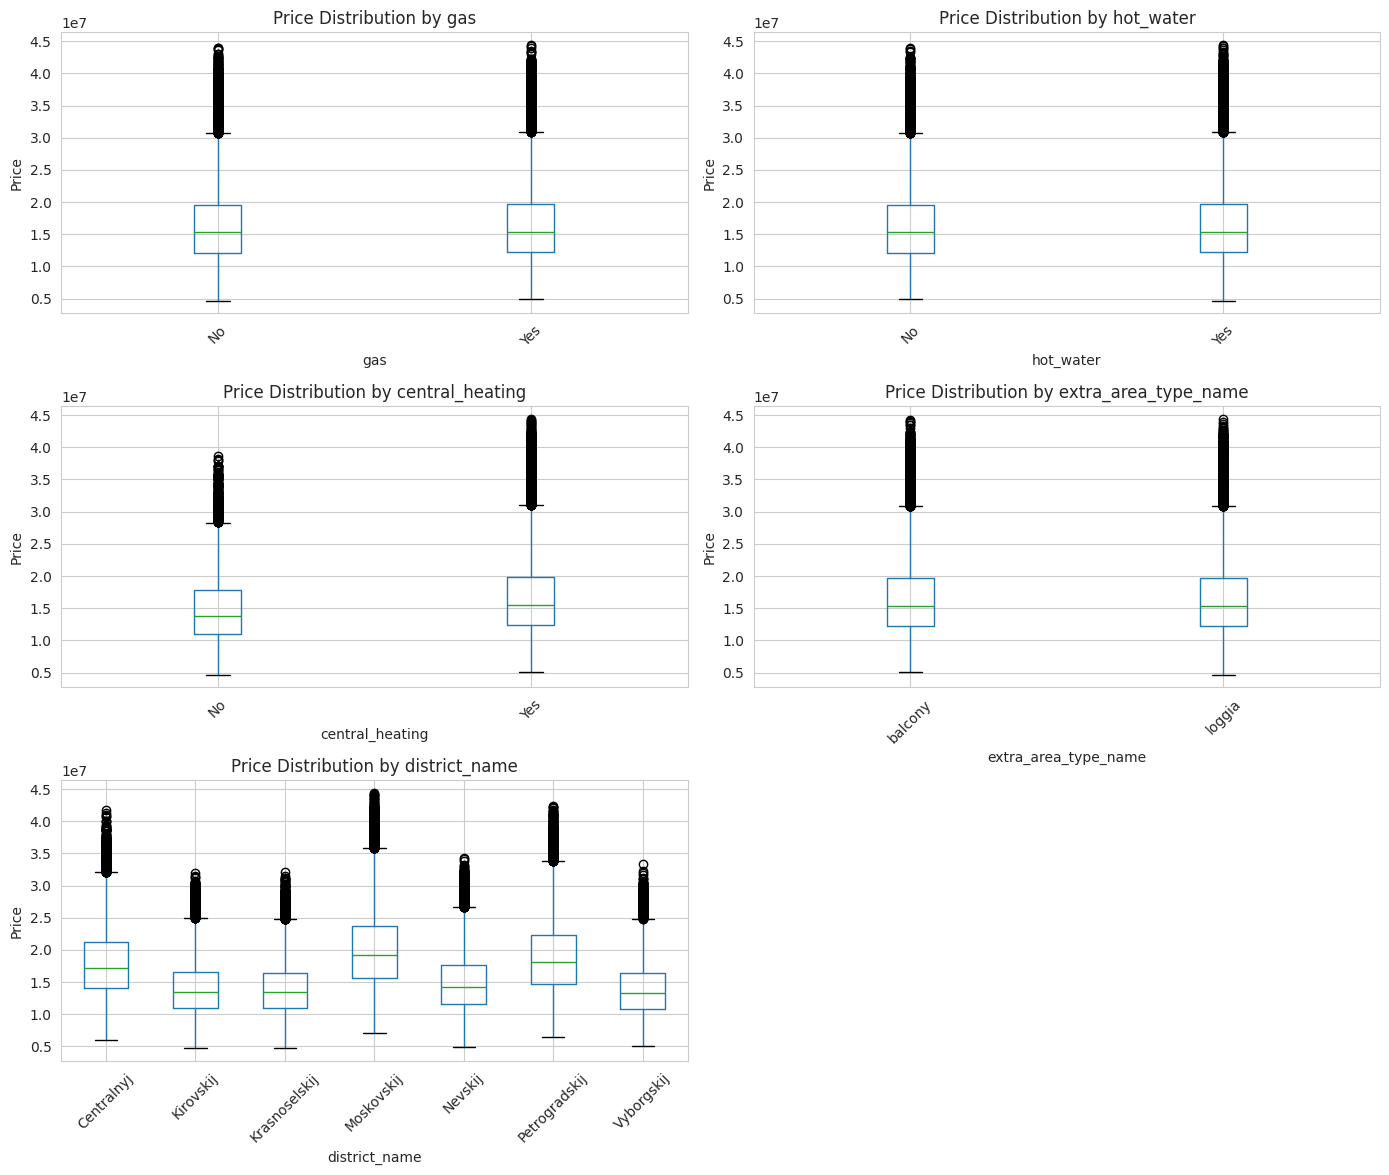

In [9]:
# ====================================================
# 5. CATEGORICAL FEATURE ANALYSIS
# ====================================================

# Categorical feature columns
categorical_cols = train_df.select_dtypes(include=['object', 'category', 'bool']).columns

# ====================================================
# 5.1 Category distributions
# ====================================================

print("Category distributions\n")

for col in categorical_cols:
    counts = train_df[col].value_counts(dropna=False)
    percentages = train_df[col].value_counts(normalize=True, dropna=False) * 100

    summary = (
        pd.DataFrame({
            'Count': counts,
            'Percent (%)': percentages.round(2)
        })
    )

    print("\n" + "="*30)
    print(f"{col} distribution")
    print("="*30)
    print(f"{col}: {train_df[col].nunique()} unique values")
    print(summary)

# count plots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, col in enumerate(categorical_cols):
    train_df[col].value_counts().plot(kind='bar', ax=axes[idx], color='teal', alpha=0.7)
    axes[idx].set_title(f'{col} Distribution', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel(col, fontsize=10)
    axes[idx].set_ylabel('Count', fontsize=10)
    axes[idx].tick_params(axis='x', rotation=45)

axes[-1].axis('off')
plt.tight_layout()
plt.savefig(f'{output_dir}/06_categorical_distributions.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# ====================================================
# 5.2 Price Variation Across Categories
# ====================================================

print("\nPrice Variation Across Categories\n")

for col in categorical_cols:
    price_stats = (
        train_df.groupby(col)['price']
        .agg(['count', 'mean', 'median', 'std'])
        .sort_values('mean', ascending=False)
    )

    print("\n" + "=" * 40)
    print(f"Price statistics by {col}")
    print("=" * 40)
    print(price_stats)


# Number of plots
n_cols = 2  # plots per row
n_rows = math.ceil(len(categorical_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    train_df.boxplot(column='price', by=col, ax=axes[i])
    axes[i].set_title(f"Price Distribution by {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Price")
    axes[i].tick_params(axis='x', rotation=45)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Remove pandas' automatic suptitle
fig.suptitle("")

# Layout + save
plt.tight_layout()
plt.savefig(f'{output_dir}/07_price_by_categorical_features.png', dpi=300, bbox_inches="tight")
plt.show()
